# Stage 0: SETUP
The following libraries are used directly. For the full list of installed packages and versions, please see requirements.txt

In [200]:
# Imports
import pandas as pd
import numpy as np

# Stage 1: DATA ACQUISITION

Data is downloaded as csv files, and is already available in this repository in the data folder. See the readme for details on the source of the data.

## Case Data
Case data is provided with dates as columns. For processing, the data is melted into a "date" column and "case_count" column, and unused columns are dropped.

In [201]:
# Get raw data, only keep used columns
raw_case_data = pd.read_csv('data/raw/RAW_us_confirmed_cases.csv').drop(columns = ["Province_State", "Admin2", "UID", "iso2", "iso3", "Country_Region", "Lat", "Long_", "code3", "Combined_Key"])


# Pivot into dat column
case_data = raw_case_data.melt(id_vars = "FIPS", var_name="date", value_name = "Case_Count").dropna(subset=['FIPS'])

# Cast types
case_data["date"] = pd.to_datetime(case_data["date"])
case_data["FIPS"] = case_data["FIPS"].astype(int).astype(str).str.pad(5, 'left', '0')
case_data.head()


,FIPS,date,Case_Count
0,01001,2020-01-22,0
1,01003,2020-01-22,0
2,01005,2020-01-22,0
3,01007,2020-01-22,0
4,01009,2020-01-22,0


## Compliance Data
Mask compliance is combined into a single score

In [202]:
# Get raw data
raw_compliance_data = pd.read_csv('data/raw/mask_use_by_county.csv')
raw_compliance_data["FIPS"] = raw_compliance_data['COUNTYFP'].astype(str).str.pad(5, 'left', '0')

# Combine into single score
raw_compliance_data["mask_compliance"] = np.dot(raw_compliance_data.iloc[:,1:6], [0, 0.25, 0.5, 0.75, 1])

# Clean
compliance_data = raw_compliance_data[["FIPS", "mask_compliance"]]
compliance_data.head()

,FIPS,mask_compliance
0,01001,0.75075
1,01003,0.74200
2,01005,0.73200
3,01007,0.83700
4,01009,0.72300


## Housing Data

In [203]:
# Get raw data, only keep used columns
use_cols = ["fips2010","li_units"]
raw_housing_data = pd.read_csv('data/raw/LIHTCPUB.CSV', usecols=use_cols)
raw_housing_data["FIPS"] = raw_housing_data["fips2010"].str[:5]

housing_data = raw_housing_data.drop(columns=["fips2010"]).groupby("FIPS").sum()
housing_data.head()

,li_units
FIPS,
01001,499.0
01003,1920.0
01005,413.0
01007,278.0
01009,275.0


## Demographic Data
Census Income and Population data are combined

In [204]:
# INCOME
# Get raw data, only keep used columns
use_cols = ["id", "Estimate!!Households!!Total", "Estimate!!Households!!Mean income (dollars)"]
raw_income_data = pd.read_csv('data/raw/income_census_data_2019.csv', header=1, usecols=use_cols)
raw_income_data.columns= ["FIPS", "household_count", "mean_income"]
raw_income_data["FIPS"] = raw_income_data["FIPS"].str[-5:]

# POPULATION
# Get raw data, only keep used columns
use_cols = ["id", "Estimate!!SEX AND AGE!!Total population"]
raw_population_data = pd.read_csv('data/raw/population_census_data_2019.csv', header=1, usecols=use_cols)
raw_population_data.columns= ["FIPS", "population"]
raw_population_data["FIPS"] = raw_population_data["FIPS"].str[-5:]

# Combine
demographic_data = raw_income_data.merge(raw_population_data, on="FIPS", how='inner')
demographic_data.head()

,FIPS,household_count,mean_income,population
0,13013,27765,77081,83240
1,13015,39742,70644,107738
2,13021,56726,67678,153159
3,13031,28660,61191,79608
4,13045,42798,69895,119992


# Stage 2: DATA PROCESSING

Merge the data on FIPS

In [205]:
# Combine on FIPS
combined_data = case_data.merge(compliance_data, on="FIPS", how='left')
combined_data = combined_data.merge(housing_data,on="FIPS", how='left')
combined_data = combined_data.merge(demographic_data,on="FIPS", how='left')
combined_data.head()

,FIPS,date,Case_Count,mask_compliance,li_units,household_count,mean_income,population
0,01001,2020-01-22,0,0.75075,499.0,NaN,NaN,NaN
1,01003,2020-01-22,0,0.74200,1920.0,NaN,NaN,NaN
2,01005,2020-01-22,0,0.73200,413.0,NaN,NaN,NaN
3,01007,2020-01-22,0,0.83700,278.0,NaN,NaN,NaN
4,01009,2020-01-22,0,0.72300,275.0,NaN,NaN,NaN


Normalize housing data on household count


In [206]:
combined_data["li_units_per_household"] = combined_data["li_units"] / combined_data["household_count"]

Add extra calculations per fip

In [207]:
# Assumed variables
active_window = 14 # Days after infection that case is active

# Calculations per FIP
combined_data.sort_values(by="date", inplace=True)

# Do rolling average of cases to account for weekly fluctiation
grouped = combined_data.groupby("FIPS")
combined_data["Case_Count_7da"] = grouped["Case_Count"].rolling(window=7).mean().reset_index(0,drop=True)
grouped = combined_data.groupby("FIPS")
combined_data["new_cases"] = grouped["Case_Count_7da"].diff().reset_index(0,drop=True).rolling(window=7).mean()
grouped = combined_data.groupby("FIPS")
combined_data["active_cases"] = grouped["new_cases"].rolling(window=active_window).sum().reset_index(0,drop=True)
combined_data["vulnerable_pop"] = combined_data["population"] - combined_data["Case_Count_7da"]

# Add extra data columns
combined_data["case_count_per_capita"] = combined_data["Case_Count"] / combined_data["population"]
combined_data["new_cases_per_capita"] = combined_data["new_cases"] / combined_data["population"]
combined_data["mean_household_size"] = combined_data["population"] / combined_data["household_count"]


combined_data[combined_data["FIPS"] == '13135'].head()

,FIPS,date,Case_Count,mask_compliance,li_units,household_count,mean_income,population,li_units_per_household,Case_Count_7da,new_cases,active_cases,vulnerable_pop,case_count_per_capita,new_cases_per_capita,mean_household_size
477,13135,2020-01-22,0,0.8355,2810.0,301471.0,93401.0,936250.0,0.009321,NaN,NaN,NaN,NaN,0.0,NaN,3.105606
3809,13135,2020-01-23,0,0.8355,2810.0,301471.0,93401.0,936250.0,0.009321,NaN,NaN,NaN,NaN,0.0,NaN,3.105606
7141,13135,2020-01-24,0,0.8355,2810.0,301471.0,93401.0,936250.0,0.009321,NaN,NaN,NaN,NaN,0.0,NaN,3.105606
10473,13135,2020-01-25,0,0.8355,2810.0,301471.0,93401.0,936250.0,0.009321,NaN,NaN,NaN,NaN,0.0,NaN,3.105606
13805,13135,2020-01-26,0,0.8355,2810.0,301471.0,93401.0,936250.0,0.009321,NaN,NaN,NaN,NaN,0.0,NaN,3.105606


Filter down to jsut the Atlanta area counties, and create a fake FIP for the entire Atlanta area.

In [208]:
# Filter down to Atlanta counties
county_fips = [
    '13057', #Cherokee
    '13063', #Clayton
    '13067', #Cobb
    '13089', #DeKalb
    '13097', #Douglas
    '13113', #Fayette
    '13117', #Forsyth
    '13121', #Fulton
    '13135', #Gwinettt
    '13151', #Henry
    '13247', #Rockdale
]
combined_data_atl = combined_data[combined_data["FIPS"].isin(county_fips)].copy()
combined_data_atl.dropna(subset=["active_cases", "population", "vulnerable_pop", "new_cases", "FIPS"])

# Add atlanta as its own category
funcMap = {
    "Case_Count": "sum",
    "Case_Count_7da": "sum",
    "mask_compliance": "mean", 
    "mean_income": "mean", 
    "population": "max", 
    "household_count":"max", 
    "mean_household_size": "mean", 
    "li_units": "max", 
    "li_units_per_household": "mean",
    "active_cases": "sum",
    "vulnerable_pop": "sum",
    "new_cases": "sum"
}
atl_data = combined_data_atl.groupby("date").agg(funcMap)
atl_data["population"] = combined_data_atl.groupby("FIPS").max().sum()["population"]
atl_data["household_count"] = combined_data_atl.groupby("FIPS").max().sum()["household_count"]
atl_data["FIPS"] = 'Atlanta'


combined_data_atl = pd.concat([combined_data_atl, atl_data.reset_index()])
combined_data_atl.head(-10)


C:\Users\ccase\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:34: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
C:\Users\ccase\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,FIPS,date,Case_Count,mask_compliance,li_units,household_count,mean_income,population,li_units_per_household,Case_Count_7da,new_cases,active_cases,vulnerable_pop,case_count_per_capita,new_cases_per_capita,mean_household_size
533,13247,2020-01-22,0,0.773000,180.0,32792.0,78651.0,90896.0,0.005489,NaN,NaN,NaN,NaN,0.0,NaN,2.771896
453,13089,2020-01-22,0,0.865500,5618.0,289829.0,94336.0,759297.0,0.019384,NaN,NaN,NaN,NaN,0.0,NaN,2.619810
443,13067,2020-01-22,0,0.811000,2278.0,286952.0,108459.0,760141.0,0.007939,NaN,NaN,NaN,NaN,0.0,NaN,2.649018
458,13097,2020-01-22,0,0.793750,316.0,48899.0,80676.0,146343.0,0.006462,NaN,NaN,NaN,NaN,0.0,NaN,2.992761
466,13113,2020-01-22,0,0.755500,337.0,41253.0,128190.0,114421.0,0.008169,NaN,NaN,NaN,NaN,0.0,NaN,2.773641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,Atlanta,2021-10-17,659457,0.811545,15094.0,1792560.0,99644.0,4901127.0,0.011512,657914.428571,201.938776,2974.938776,4.243213e+06,NaN,NaN,2.822757
635,Atlanta,2021-10-18,660811,0.811545,15094.0,1792560.0,99644.0,4901127.0,0.011512,658924.714286,219.673469,2962.795918,4.242202e+06,NaN,NaN,2.822757
636,Atlanta,2021-10-19,661467,0.811545,15094.0,1792560.0,99644.0,4901127.0,0.011512,659574.000000,191.755102,2934.469388,4.241553e+06,NaN,NaN,2.822757
637,Atlanta,2021-10-20,662153,0.811545,15094.0,1792560.0,99644.0,4901127.0,0.011512,660205.000000,186.530612,2895.755102,4.240922e+06,NaN,NaN,2.822757


# Stage 3: MODELING

Here we model infection rates and case counts. The model is 

$$
C_{new} = P_v(1 - (1 - r)^{\frac{C_{active}}{P_{total}}x})
$$

Where $C_{new}$ and $C_{active}$ are new and active cases, $P_v$ and $P_{total}$ are vulnerable and total population, r is the transmission rate and x is the exposure rate.

In [209]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [210]:
def transmissionModel(data, r, x):
    c_active = data["active_cases"]
    p_total = data["population"]
    p_vuln = data["vulnerable_pop"]
    daily_exposures = c_active / p_total * x
    return p_vuln * (1 - pow( 1 - r,daily_exposures))

We fit r and x to a dataset. r is bound between 0 and 1, since it's a probability, and x is bounded from 0 to 1000 to help in optimizing the curve fit.

In [211]:
from scipy.optimize import curve_fit

def getTransmissionVariables(data):
    y = data["new_cases"]
    X = data[["active_cases", "population", "vulnerable_pop"]]
    
    #Don't model blank periods
    if y.sum() <= 0:
        return (np.NaN, np.NaN)
    
    popt, pcov = curve_fit(transmissionModel, X, y, p0 = [0.03, 3], bounds=(0, [1,1000]))
    return popt


A simulation confirms that the model creates bell-shaped curves, and that changing the parameters does result in differences in curve characteristics. Changing r and x below, one can expiriment with their impacts on the curve.

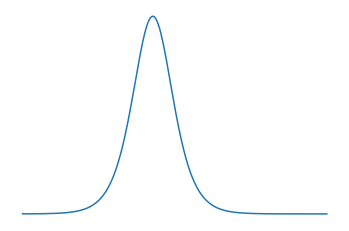

In [212]:
# Simulate 
p_t = 1000000
p_v = p_t
new_cases = [10]
active_cases = new_cases[0]
r = 0.001
x = 100
while p_v > 0 and active_cases >= 1:
    active_cases = np.sum(new_cases[-14:])
    data = {"active_cases": active_cases, "population": p_t, "vulnerable_pop": p_v}
    new_cases.append(transmissionModel(data, r, x))
    p_v -= new_cases[-1]

#Plot
plt.plot(new_cases)
plt.axis('off')
plt.show()

For each month in each county, we calculate the values

In [213]:
# Group by month
combined_data_atl["month"] = combined_data_atl["date"].dt.strftime('%y-%m')

# Drill down to specific columns and drop na
model_data = combined_data_atl[["FIPS", "month", "new_cases","active_cases", "population", "vulnerable_pop"]].dropna()

#Groupby month and apply
model_fits = model_data.groupby(["FIPS", "month"]).apply(getTransmissionVariables)
model_fits.columns = ["x"]
model_fits = pd.DataFrame(model_fits.tolist(), index=model_fits.index, columns = ["transmission_chance", "exposure_rate"]).dropna()

# Merge results back into combined data
modeled_data = combined_data_atl.merge(model_fits, on=["FIPS", "month"])
modeled_data["modeled_new_cases"] = transmissionModel(modeled_data, modeled_data["transmission_chance"], modeled_data["exposure_rate"])
modeled_data.head(-10)

,FIPS,date,Case_Count,mask_compliance,li_units,household_count,mean_income,population,li_units_per_household,Case_Count_7da,new_cases,active_cases,vulnerable_pop,case_count_per_capita,new_cases_per_capita,mean_household_size,month,transmission_chance,exposure_rate,modeled_new_cases
0,13247,2020-03-01,0,0.773000,180.0,32792.0,78651.0,90896.0,0.005489,0.000000,0.000000,2.842171e-13,9.089600e+04,0.0,0.0,2.771896,20-03,0.034734,5.838598,0.000000
1,13247,2020-03-02,0,0.773000,180.0,32792.0,78651.0,90896.0,0.005489,0.000000,0.000000,2.842171e-13,9.089600e+04,0.0,0.0,2.771896,20-03,0.034734,5.838598,0.000000
2,13247,2020-03-03,0,0.773000,180.0,32792.0,78651.0,90896.0,0.005489,0.000000,0.000000,2.842171e-13,9.089600e+04,0.0,0.0,2.771896,20-03,0.034734,5.838598,0.000000
3,13247,2020-03-04,0,0.773000,180.0,32792.0,78651.0,90896.0,0.005489,0.000000,0.000000,2.842171e-13,9.089600e+04,0.0,0.0,2.771896,20-03,0.034734,5.838598,0.000000
4,13247,2020-03-05,0,0.773000,180.0,32792.0,78651.0,90896.0,0.005489,0.000000,0.000000,2.842171e-13,9.089600e+04,0.0,0.0,2.771896,20-03,0.034734,5.838598,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7305,Atlanta,2021-10-17,659457,0.811545,15094.0,1792560.0,99644.0,4901127.0,0.011512,657914.428571,201.938776,2.974939e+03,4.243213e+06,NaN,NaN,2.822757,21-10,0.025706,2.573654,172.619303
7306,Atlanta,2021-10-18,660811,0.811545,15094.0,1792560.0,99644.0,4901127.0,0.011512,658924.714286,219.673469,2.962796e+03,4.242202e+06,NaN,NaN,2.822757,21-10,0.025706,2.573654,171.873802
7307,Atlanta,2021-10-19,661467,0.811545,15094.0,1792560.0,99644.0,4901127.0,0.011512,659574.000000,191.755102,2.934469e+03,4.241553e+06,NaN,NaN,2.822757,21-10,0.025706,2.573654,170.204539
7308,Atlanta,2021-10-20,662153,0.811545,15094.0,1792560.0,99644.0,4901127.0,0.011512,660205.000000,186.530612,2.895755e+03,4.240922e+06,NaN,NaN,2.822757,21-10,0.025706,2.573654,167.934098


We can see how close our fit was for Gwinett. The model visually follow the actual cases, and a high R-squared of 89.7 confirms that this is a reasonably good fit.

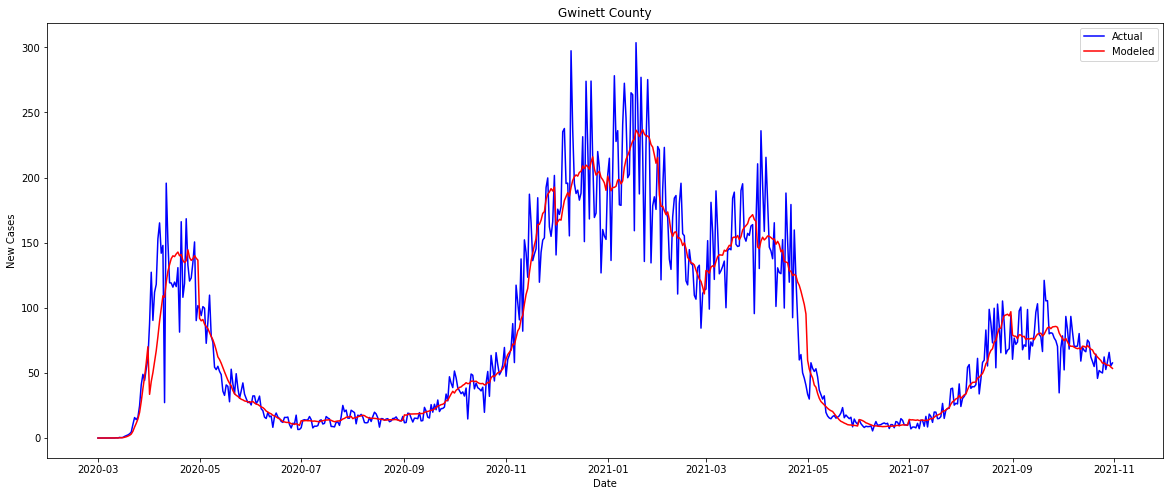

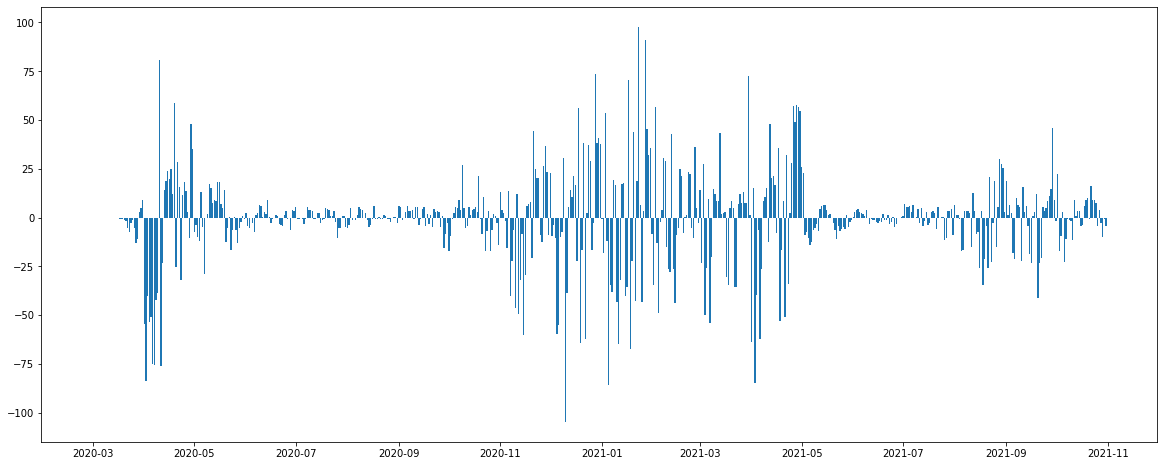


        MSE: 0.6442939430453022
        Average Error: 0.17853206765687235
        R^2: 0.8969792892917416
    


In [214]:
def evaluateFit(y, y_fit):
    # residuals
    res = (y - y_fit)
    ss_res = np.sum(res ** 2)

    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    
    print("""
        MSE: {}
        Average Error: {}
        R^2: {}
    """.format(np.mean(res), np.mean(np.abs(res)/np.mean(y)), r2)
    )

def plotModel(index, actual, modeled, title=None, showErrors=False):

    plt.figure(figsize=(20,8))
    plt.plot(index, actual, 'b-', label='Actual')
    plt.plot(index, modeled, 'r-', label='Modeled')

    plt.xlabel('Date')
    plt.ylabel('New Cases')
    
    if title:
        plt.title(title)
    plt.legend()
    plt.show()

    if showErrors:
        plt.figure(figsize=(20,8))
        plt.bar(index, modeled - actual, label='Errors')
        plt.show()

target_county = modeled_data[modeled_data["FIPS"] == '13135']
plotModel(target_county["date"], target_county["new_cases"], target_county["modeled_new_cases"], "Gwinett County", True)
evaluateFit(target_county["new_cases"], target_county["modeled_new_cases"])


We can compare Gwinnett and Atlanta

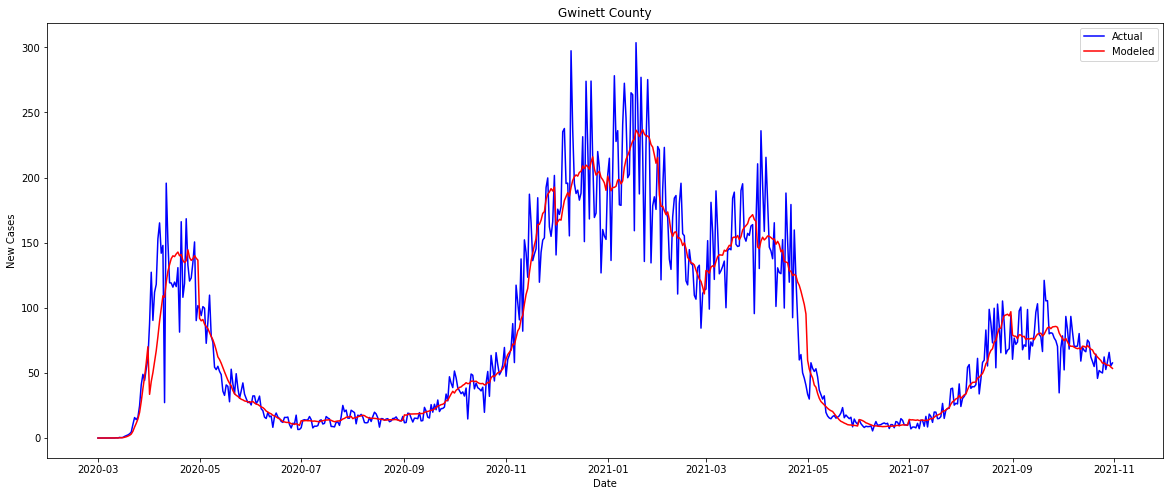

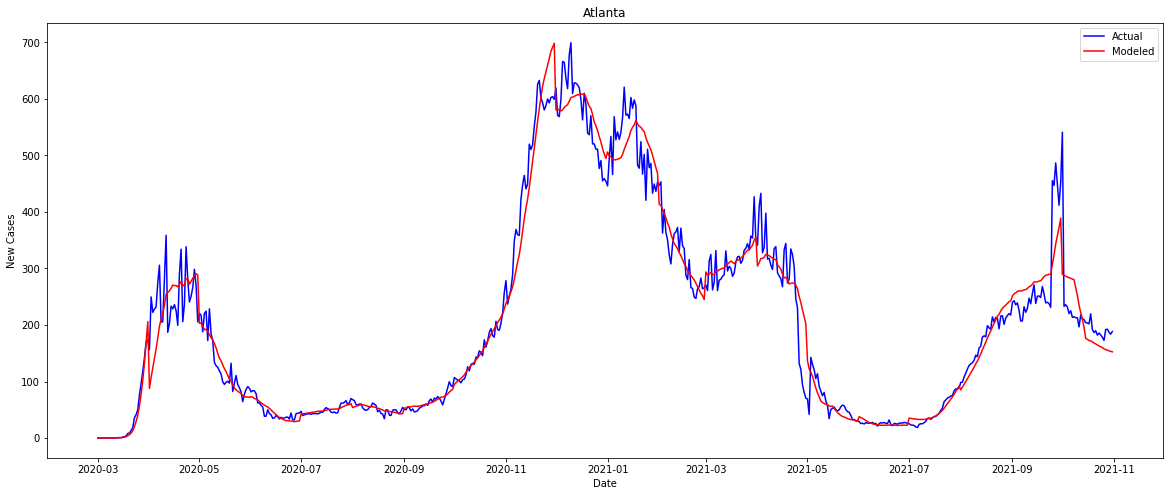

Gwinnett

        MSE: 0.6442939430453022
        Average Error: 0.17853206765687235
        R^2: 0.8969792892917416
    
Atlanta

        MSE: 1.4144744259596813
        Average Error: 0.11305587098717472
        R^2: 0.9576439365254026
    


In [215]:
target_county = modeled_data[modeled_data["FIPS"] == '13135']
atl = modeled_data[modeled_data["FIPS"] == 'Atlanta']
plotModel(target_county["date"], target_county["new_cases"], target_county["modeled_new_cases"], "Gwinett County")
plotModel(atl["date"], atl["new_cases"], atl["modeled_new_cases"], "Atlanta")

print("Gwinnett")
evaluateFit(target_county["new_cases"], target_county["modeled_new_cases"])
print("Atlanta")
evaluateFit(atl["new_cases"], atl["modeled_new_cases"])

Parameters align closely between Gwinnett and Atlanta, but in areas where the case count curves diverge, a divergence in the parameters is visible as well.

In [216]:
import matplotlib.ticker as mtick

def compareParameters(model_data, target_fip, param_name):
    
    # Filter data
    target_county = model_data.loc[target_fip,:].reset_index()
    atl_area = model_data.loc['Atlanta',:].reset_index()
    xvals = atl_area.index

    # Create figure
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(111)
    
    # Add bars
    w = 0.4
    ax.bar(xvals - w/2, target_county[param_name], width=w, label='Gwinnett')
    ax.bar(xvals + w/2, atl_area[param_name], width=w, label='Atlanta')
    
    # Label months
    plt.xlabel('Month')
    ax.set_xticks(xvals)
    ax.set_xticklabels(target_county["month"])

    # Label values
    if param_name == 'transmission_chance':
        plt.ylabel('Transmission Chance')
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, 1))
        plt.title('Transmission Chance Comparison')
    else:
        plt.ylabel('Daily Exposures')
        plt.title('Exposure Rate Comparison')

    plt.legend()
    plt.show()

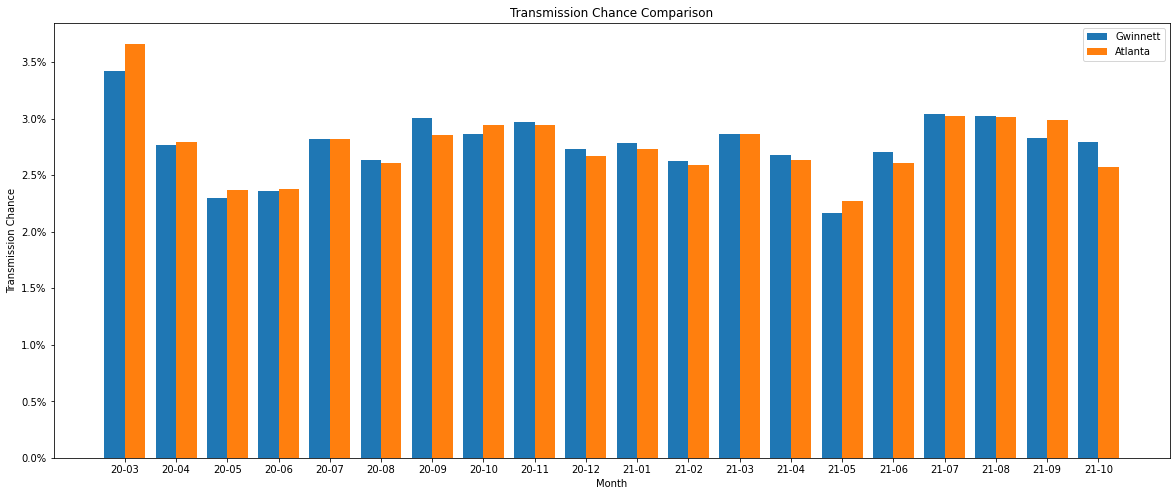

In [217]:
compareParameters(model_fits, '13135', 'transmission_chance')

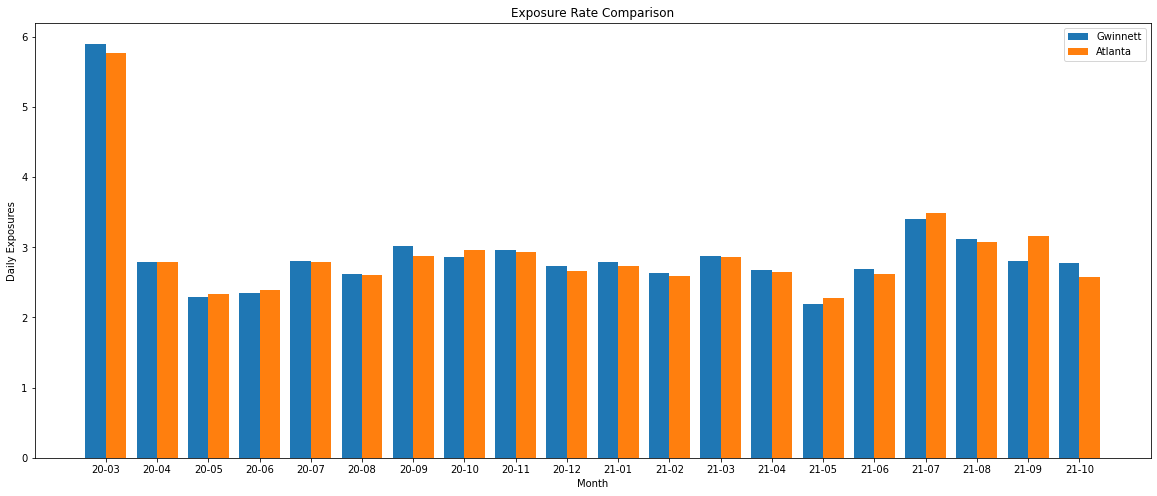

In [218]:
compareParameters(model_fits, '13135', 'exposure_rate')

October 2020 provides one example, we examine that actual case counts and paramtere variables for this month.

In [219]:
df = modeled_data.copy()[modeled_data["month"] == '20-08']
df["new_cases_per_capita_diff"] =  df["new_cases_per_capita"] - df["new_cases_per_capita"].mean()
net_cases = df.groupby("FIPS")["Case_Count"].max().sum()
net_pop = df.groupby("FIPS")["population"].mean().sum()
df = pd.DataFrame({"new_cases": df.groupby("FIPS")["new_cases_per_capita_diff"].mean(),
             "case_count": df.groupby("FIPS")["case_count_per_capita"].max() - net_cases/net_pop,
             })

pd.concat([df, model_fits.groupby("FIPS").mean() - model_fits.mean()], axis=1)

,new_cases,case_count,transmission_chance,exposure_rate
FIPS,,,,
13057,-8.926301e-06,-0.003249,0.000432,0.068527
13063,-1.015267e-05,0.000151,0.000300,-0.032457
13067,-1.260864e-05,0.000305,0.000245,0.053550
13089,-1.428669e-05,-0.000212,-0.000583,-0.165179
13097,-8.250760e-06,-0.000374,0.003053,0.056162
13113,3.485966e-05,-0.008267,-0.000772,0.063001
13117,3.959484e-06,-0.009360,-0.000586,0.035125
13121,-7.578505e-06,0.001380,-0.000360,-0.004518
13135,5.940374e-07,0.003889,-0.000152,0.006381


# Stage 4: ANALYSIS

We now analyze how our demogrpahic data relates to the modelled parameters

Each month is a data point

In [220]:
x_vars = ["mask_compliance", "li_units_per_household", "mean_household_size", "mean_income", "active_cases"]
y_vars = ["transmission_chance", "exposure_rate"]
monthly = modeled_data.groupby(["FIPS", "month"])[x_vars + y_vars].mean()
X = monthly[x_vars]
monthly

mask_compliance  li_units_per_household  mean_household_size  \
FIPS    month                                                                 
13057   20-03         0.807250                0.008294             2.769373   
        20-04         0.807250                0.008294             2.769373   
        20-05         0.807250                0.008294             2.769373   
        20-06         0.807250                0.008294             2.769373   
        20-07         0.807250                0.008294             2.769373   
...                        ...                     ...                  ...   
Atlanta 21-06         0.811545                0.011512             2.822757   
        21-07         0.811545                0.011512             2.822757   
        21-08         0.811545                0.011512             2.822757   
        21-09         0.811545                0.011512             2.822757   
        21-10         0.811545                0.011512             2.822757   

               mean_income  active_cases  transmission_chance  exposure_rate  
FIPS    month                                                                 
13057   20-03     101950.0      0.114549             0.032735       5.732114  
        20-04     101950.0      4.278231             0.028814       2.856401  
        20-05     101950.0      7.685978             0.026270       2.526533  
        20-06     101950.0      5.507483             0.031815       2.942137  
        20-07     101950.0     18.071758             0.028166       2.839931  
...                    ...           ...                  ...            ...  
Atlanta 21-06      99644.0    407.493878             0.026060       2.617694  
        21-07      99644.0    496.279131             0.030263       3.487327  
        21-08      99644.0   2019.323239             0.030100       3.071861  
        21-09      99644.0   3422.069388             0.029842       3.159403  
        21-10      99644.0   3574.588545             0.025706       2.573654  

[240 rows x 7 columns]

Some colinnearity is present

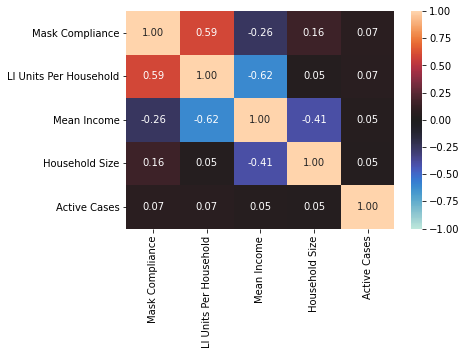

In [221]:
import seaborn as sn

df = X.copy()
df.columns = ["Mask Compliance", "LI Units Per Household", "Mean Income", "Household Size", "Active Cases"]
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True, fmt='.2f', center=0, vmin = -1)
plt.show()

### Transmission Chance

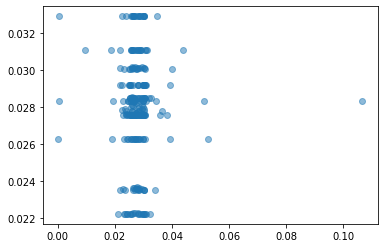

mask_compliance           0.061746
li_units_per_household    1.743925
mean_household_size       0.673423
mean_income               0.999998
active_cases              1.000002
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                  
===============================================================================
Dep. Variable:     transmission_chance   No. Observations:                  240
Model:                             GLM   Df Residuals:                      235
Model Family:         NegativeBinomial   Df Model:                            4
Link Function:                     log   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -30.741
Date:                 Mon, 13 Dec 2021   Deviance:                      0.48213
Time:                         21:02:22   Pearson chi2:                    0.501
No. Iterations:                      4                                         
Covariance Type:                   HC3                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
mask_compliance           -2.7847      0.477     -5.841      0.000      -3.719      -1.850
li_units_per_household     0.5561      2.267      0.245      0.806      -3.888       5.000
mean_household_size       -0.3954      0.111     -3.570      0.000      -0.612      -0.178
mean_income            -2.154e-06   9.13e-07     -2.359      0.018   -3.94e-06   -3.65e-07
active_cases            2.285e-06   7.44e-06      0.307      0.759   -1.23e-05    1.69e-05
==========================================================================================
"""

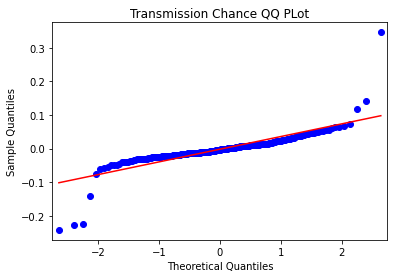

In [222]:
import statsmodels.api as sm
from statsmodels import graphics

y = monthly["transmission_chance"]
glm = sm.GLM(y, X, family=sm.families.NegativeBinomial())
results = glm.fit(cov_type='HC3')

plt.plot(y, results.predict(X), 'o', alpha=0.5);
plt.show()

print(np.exp(results.params))

resid = results.resid_deviance.copy()
graphics.gofplots.qqplot(resid, line='r')
plt.title('Transmission Chance QQ PLot')

results.summary()


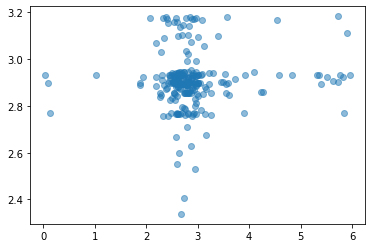

mask_compliance           1.569414
li_units_per_household    2.971750
mean_household_size       1.226396
mean_income               1.000001
active_cases              0.999973
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          exposure_rate   No. Observations:                  240
Model:                            GLM   Df Residuals:                      235
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -377.98
Date:                Mon, 13 Dec 2021   Deviance:                       55.081
Time:                        21:02:22   Pearson chi2:                     54.7
No. Iterations:                     4                                         
Covariance Type:                  HC3                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
mask_compliance            0.4507      0.562      0.802      0.422      -0.650       1.552
li_units_per_household     1.0892      3.255      0.335      0.738      -5.290       7.469
mean_household_size        0.2041      0.123      1.656      0.098      -0.037       0.446
mean_income             1.248e-06   1.09e-06      1.147      0.251   -8.84e-07    3.38e-06
active_cases            -2.74e-05    9.8e-06     -2.797      0.005   -4.66e-05    -8.2e-06
==========================================================================================
"""

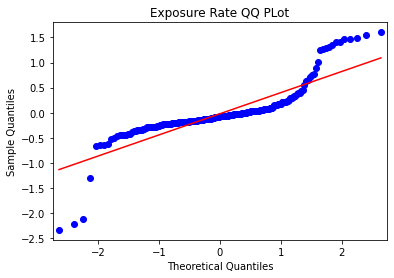

In [223]:
y = monthly["exposure_rate"]
glm = sm.GLM(y, X, family=sm.families.Poisson())
results = glm.fit(cov_type='HC3')

plt.plot(y, results.predict(X), 'o', alpha=0.5);
plt.show()

print(np.exp(results.params))

resid = results.resid_deviance.copy()
graphics.gofplots.qqplot(resid, line='r')
plt.title('Exposure Rate QQ PLot')

results.summary()

Applying the difference between Atlanta and Gwinnett, we see the changes attributable to them

In [224]:
np.exp(results.params) * comparison_df["Diff"] / comparison_df["Atlanta"]


FIPS                           NaN
active_cases              -0.62105
household_count                NaN
li_units                       NaN
li_units_per_household   -0.565532
mask_compliance           0.046325
mean_household_size       0.122889
mean_income              -0.062653
new_cases                      NaN
population                     NaN
vulnerable_pop                 NaN
dtype: object